<a href="https://colab.research.google.com/github/HaavardM/ais-predict/blob/master/samples/master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip3 install --upgrade geopandas google-cloud-bigquery google-cloud-bigquery-storage pyarrow gpflow
!pip3 install git+https://github.com/Haavardm/ais-predict.git

Requirement already up-to-date: geopandas in /usr/local/lib/python3.7/dist-packages (0.9.0)
Requirement already up-to-date: google-cloud-bigquery in /usr/local/lib/python3.7/dist-packages (2.11.0)
Requirement already up-to-date: google-cloud-bigquery-storage in /usr/local/lib/python3.7/dist-packages (2.3.0)
Requirement already up-to-date: pyarrow in /usr/local/lib/python3.7/dist-packages (3.0.0)
Requirement already up-to-date: gpflow in /usr/local/lib/python3.7/dist-packages (2.1.4)
  Cloning https://github.com/Haavardm/ais-predict.git to /tmp/pip-req-build-uwuihjks
  Running command git clone -q https://github.com/Haavardm/ais-predict.git /tmp/pip-req-build-uwuihjks
ERROR: Files/directories not found in /tmp/pip-req-build-uwuihjks/pip-egg-info


In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

     |████████████████████████████████| 1.0MB 10.9MB/s 
     |████████████████████████████████| 256kB 36.1MB/s 
     |████████████████████████████████| 6.5MB 50.1MB/s 
     |████████████████████████████████| 14.8MB 309kB/s 
Authenticated


In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd
from google.cloud import bigquery, bigquery_storage
import google.auth
import matplotlib
import matplotlib.pyplot as plt
import pyproj
import gpflow
matplotlib.rcParams['figure.figsize'] = (15, 15)

In [4]:
credentials, your_project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

# Make clients.
bq = bigquery.Client(credentials=credentials, project="master-thesis-305112",)
bqstorage = bigquery_storage.BigQueryReadClient(credentials=credentials)

In [5]:
query = """
SELECT CAST(mmsi AS string) as mmsi, timestamp, prev_timestamp, ST_X(position) AS long, ST_Y(position) AS lat, ST_X(prev_position) AS prev_long, ST_Y(prev_position) AS prev_lat
FROM `master-thesis-305112.ais.processed_filtered`
WHERE mmsi IN (SELECT mmsi FROM `master-thesis-305112.ais.ship_configurations` ORDER BY RAND() LIMIT 16)
ORDER BY mmsi, timestamp
"""
df = bq.query(query).result().to_dataframe(bqstorage_client=bqstorage)

TypeError: ignored

In [ ]:
df

,mmsi,timestamp,prev_timestamp,long,lat,prev_long,prev_lat
0,227731000,2015-02-12 10:30:28.999987+00:00,2015-02-12 10:20:28.000032+00:00,8.183178,63.285992,8.139022,63.273235
1,227731000,2015-02-12 11:01:00.000019+00:00,2015-02-12 10:52:29.000006+00:00,8.307940,63.333640,8.273407,63.319600
2,227731000,2015-02-12 11:10:59.999980+00:00,2015-02-12 11:01:00.000019+00:00,8.345665,63.349478,8.307940,63.333640
3,227731000,2015-02-12 11:22:27.999984+00:00,2015-02-12 11:10:59.999980+00:00,8.390528,63.366832,8.345665,63.349478
4,227731000,2015-02-12 11:32:28.000032+00:00,2015-02-12 11:22:27.999984+00:00,8.433200,63.378358,8.390528,63.366832
...,...,...,...,...,...,...,...
26222,311411000,2015-12-11 14:06:48.000038+00:00,2015-12-11 14:00:47.000015+00:00,7.981227,63.236368,8.020017,63.245508
26223,311411000,2015-12-11 14:12:58.000003+00:00,2015-12-11 14:06:48.000038+00:00,7.942625,63.227770,7.981227,63.236368
26224,311411000,2015-12-11 14:16:18.000019+00:00,2015-12-11 14:12:58.000003+00:00,7.922352,63.223103,7.942625,63.227770
26225,311411000,2015-12-11 14:19:07.999968+00:00,2015-12-11 14:16:18.000019+00:00,7.905232,63.219025,7.922352,63.223103


In [ ]:
x, y = pyproj.transform("wgs84", "epsg:3035", df.long, df.lat)
px, py =  pyproj.transform("wgs84", "epsg:3035", df.prev_long, df.prev_lat)
df["x"] = ((x + px) / 2 - min(px)) / 1000 
df["y"] = ((y + py) / 2 - min(py)) / 1000
df["dx"] = 3.6 * (x - px) / (df.timestamp - df.prev_timestamp).dt.total_seconds()
df["dy"] = 3.6 * (y - py) / (df.timestamp - df.prev_timestamp).dt.total_seconds()
df["angle"] = np.arctan2(df.dy, df.dx)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  


In [ ]:
df

,mmsi,timestamp,prev_timestamp,long,lat,prev_long,prev_lat,x,y,dx,dy,angle
0,227731000,2015-02-12 10:30:28.999987+00:00,2015-02-12 10:20:28.000032+00:00,8.183178,63.285992,8.139022,63.273235,39.137106,77.192377,31.807198,-3.361731,-0.105300
1,227731000,2015-02-12 11:01:00.000019+00:00,2015-02-12 10:52:29.000006+00:00,8.307940,63.333640,8.273407,63.319600,55.413097,76.427562,31.331812,-0.467951,-0.014934
2,227731000,2015-02-12 11:10:59.999980+00:00,2015-02-12 11:01:00.000019+00:00,8.345665,63.349478,8.307940,63.333640,60.084120,76.380188,29.368017,-0.169948,-0.005787
3,227731000,2015-02-12 11:22:27.999984+00:00,2015-02-12 11:10:59.999980+00:00,8.390528,63.366832,8.345665,63.349478,65.387911,76.278211,29.893148,-0.918992,-0.030733
4,227731000,2015-02-12 11:32:28.000032+00:00,2015-02-12 11:22:27.999984+00:00,8.433200,63.378358,8.390528,63.366832,70.780138,75.872773,30.429242,-3.811472,-0.124608
...,...,...,...,...,...,...,...,...,...,...,...,...
26222,311411000,2015-12-11 14:06:48.000038+00:00,2015-12-11 14:00:47.000015+00:00,7.981227,63.236368,8.020017,63.245508,20.394724,79.932870,-45.032606,6.754037,2.992721
26223,311411000,2015-12-11 14:12:58.000003+00:00,2015-12-11 14:06:48.000038+00:00,7.942625,63.227770,7.981227,63.236368,15.907827,80.630744,-43.375365,6.990507,2.981804
26224,311411000,2015-12-11 14:16:18.000019+00:00,2015-12-11 14:12:58.000003+00:00,7.922352,63.223103,7.942625,63.227770,12.502621,81.171125,-42.343009,6.521267,2.988783
26225,311411000,2015-12-11 14:19:07.999968+00:00,2015-12-11 14:16:18.000019+00:00,7.905232,63.219025,7.922352,63.223103,10.328156,81.498546,-42.279672,6.195176,2.996100


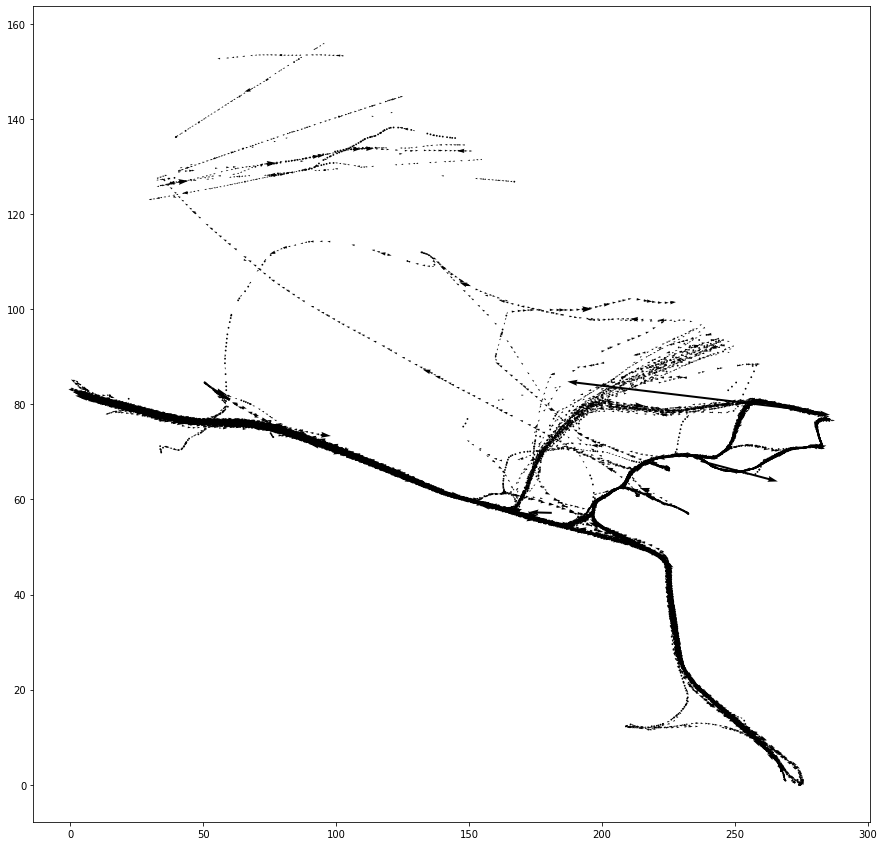

In [ ]:
d = df.copy()


plt.quiver(d.x, d.y, d.dx, d.dy)

#plt.xlim([200, 250])
#plt.ylim([25, 75])

In [ ]:


#pred, std = gp.predict(pred_x, return_std=True)
#plot(pred, std)


In [ ]:
import gpflow as gpf
import tensorflow as tf
gpf.config.set_default_float(np.float64)
gpf.config.set_default_summary_fmt("notebook")


d = df
d = d.loc[d.x < 275]
d = d.loc[d.x > 200]
d = d.loc[d.y < 50]
x = d[["x", "y"]].to_numpy()
y = d[["dx", "dy"]].to_numpy() 
#y[y[:, 0] < 0] *= -1

kernel = gpf.kernels.SharedIndependent(
    gpf.kernels.Matern52(variance=1, lengthscales=1) + 
    #gpf.kernels.RationalQuadratic(lengthscales=1, variance=10, alpha=10) + 
    gpf.kernels.White(1), output_dim=2
)
#iX, iY = np.mgrid[min(x[:, 0]):max(x[:, 0]):20j, min(x[:, 1]):max(x[:, 1]):20j]
inducing_points = x #np.vstack([iX.ravel(), iY.ravel()]).transpose()
iv = gpf.inducing_variables.SharedIndependentInducingVariables(
    gpf.inducing_variables.InducingPoints(inducing_points)
)

m = gpf.models.SVGP(kernel, gpf.likelihoods.Gaussian(), inducing_variable=iv, num_latent_gps=2)

#gpf.set_trainable(m.inducing_variable, False)


def optimize_model_with_scipy(model):
    optimizer = tf.optimizers.Adam()
    train_data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y))).repeat().shuffle(x.shape[0])
    training_loss = model.training_loss_closure(iter(train_data.batch(100)), compile=True)
    @tf.function
    def step():
      optimizer.minimize(
        training_loss,
        model.trainable_variables,
      )

    logf = np.zeros(4000)
    for i in range(len(logf)):
      step()
      logf[i] = -training_loss().numpy()
      if i % 100 == 0:
        print(i)
    return logf
gpf.utilities.print_summary(m)
plt.plot(optimize_model_with_scipy(m))
gpf.utilities.print_summary(m)






name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
SVGP.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,1.0
SVGP.inducing_variable.inducing_variable.Z,Parameter,Identity,,True,"(4814, 2)",float64,"[[221.63808431, 48.99022314..."
SVGP.q_mu,Parameter,Identity,,True,"(4814, 2)",float64,"[[0., 0...."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 4814, 4814)",float64,"[[[1., 0., 0...."


0
100


In [ ]:
pX, pY = np.mgrid[min(x[:, 0]):max(x[:, 0]):40j, min(x[:, 1]):max(x[:, 1]):40j]
pred_x = np.vstack([pX.ravel(), pY.ravel()]).transpose()
def plot(pred_x, pred, std):
  row_filter = np.any(np.abs(pred) > 1e-6, axis=1) & (std < 0.9*max(std))
  print(row_filter)
  pred /= np.linalg.norm(pred, axis=1).reshape(-1, 1)
  plt.pcolormesh(pX, pY, std.reshape(pY.shape), cmap="Greys")
  plt.quiver(*x[:, :2].transpose(), *y.transpose(), color="blue")
  plt.quiver(*pred_x[row_filter, :2].transpose(), *pred[row_filter, :].transpose(), color="red")
  plt.xlim([pX[0, 0], pX[-1, -1]])
  plt.ylim([pY[0, 0], pY[-1, -1]])
print(pred_x.shape)
pred_y = m.predict_y(pred_x)
mean, std = pred_y
print(mean)
plot(pred_x, mean.numpy(), np.linalg.norm(std.numpy(), axis=1))

In [ ]:
print(d)

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

d = df
d = d.loc[d.x < 275]
d = d.loc[d.x > 200]
d = d.loc[d.y < 50]
#d = d.sample(1000)
x = d[["x", "y"]].to_numpy()
y = d[["dx", "dy"]].to_numpy() 
y[y[:, 0] < 0, :] *= -1
gp = GaussianProcessRegressor(Matern(1), alpha=0.2, n_restarts_optimizer=10)
gp = gp.fit(x, y)

In [ ]:
pX, pY = np.mgrid[min(x[:, 0]):max(x[:, 0]):40j, min(x[:, 1]):max(x[:, 1]):40j]
pred_x = np.vstack([pX.ravel(), pY.ravel()]).transpose()
def plot(pred_x, pred, std):
  row_filter = np.any(np.abs(pred) > 1e-6, axis=1) & (std < 0.9*max(std))
  pred /= np.linalg.norm(pred, axis=1).reshape(-1, 1)
  plt.pcolormesh(pX, pY, std.reshape(pY.shape), cmap="Greys")
  plt.quiver(*x[:, :2].transpose(), *y.transpose(), color="blue")
  plt.quiver(*pred_x[row_filter, :2].transpose(), *pred[row_filter, :].transpose(), color="red")
  plt.xlim([pX[0, 0], pX[-1, -1]])
  plt.ylim([pY[0, 0], pY[-1, -1]])
pred_y = gp.predict(pred_x, return_std=True)
print(gp.get_params())
print(pred_y)
mean, std = pred_y
plot(pred_x, mean, std)

In [ ]:
gp.predict([[45, 230]], return_cov=True)

In [ ]:
x_0 = [229, 50]
x_0 = np.concatenate([x_0, [0, 0]]).reshape((1, -1))
tx = np.zeros((1000, 4))
tstd = np.zeros((1000, 2))
tx[0] = x_0
tstd[0] = [1, 1]


#@tf.function
#def func(x):
#  return m.predict_f(x)

dt = 0.01



F = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0 ],
              [0, 0, 0, 1]]
)

P = np.zeros((tx.shape[0], 4, 4))
P[0, :, :] = np.eye(4)
H = np.array([[0, 0, 1, 0],
     [0, 0, 0, 1]])

Q = np.array([[((dt**3) / 3), 0, ((dt**2) / 2), 0],
              [0, ((dt**3) / 3), 0, ((dt**2) / 2)],
              [((dt**2) / 2), 0, dt, 0],
              [0, ((dt**2) / 2), 0, dt]]) * 100

for t in range(1, len(tx)):

  # Predict
  x_pred = F @ tx[t-1, :]
  P_pred = F @ P[t-1, :, :] @ F.T + Q
  z_pred = H @ x_pred

  # Measure
  z, s = gp.predict(x_pred[:2].reshape((1, -1)), return_std=True)
  z = z.flatten()
  s = s.flatten()
  # Update
  v = z - z_pred
  S = H @ P_pred @ H.T + np.eye(2)*(s**2)
  W = P_pred @ H.T @ np.linalg.inv(S)
  tx[t, :] = x_pred + W @ v
  P[t, :, :] = (np.eye(4)-W @ H) @ P_pred
plot(pred_x, mean, std)
plt.plot(*tx.T, color="green", linewidth=5)
plt.fill_between(tx[:, 0], tx[:, 1] + 2 * tstd[:, 1], tx[:, 1] - 2*tstd[:, 1], alpha=0.7, color="green")
plt.fill_betweenx(tx[:, 1], tx[:, 0] - 2 * tstd[:, 0], tx[:, 0] + 2*tstd[:, 0], alpha=0.7, color="green")

  

In [ ]:
plt.subplot(2, 2, 1)
plt.plot(tx[:, 0])
plt.subplot(2, 2, 2)
plt.plot(tx[:, 1])
plt.subplot(2, 2, 3)
plt.plot(tx[:, 2])
plt.subplot(2, 2, 4)
plt.plot(tx[:, 3])




In [ ]:
plt.plot(np.linalg.norm(np.diagonal(P, axis1=1, axis2=2), axis=1))

In [ ]:
models = []
d["bucket"] = np.floor(d["angle"] / (np.pi / 4))
for name, t in d.groupby(["bucket"]):
  print(name)
  gp = GaussianProcessRegressor(4*Matern(length_scale=2,nu=2.5), alpha=1.2, optimizer=None)
  tx = t[["x", "y"]].to_numpy()
  ty = t[["dx", "dy"]].to_numpy()
  #ty[ty[:, 0] < 0, :] *= -1
  models.append(gp.fit(tx, ty))

In [ ]:
models

In [ ]:
pX, pY = np.mgrid[min(x[:, 0]):max(x[:, 0]):40j, min(x[:, 1]):max(x[:, 1]):40j]
pred_x = np.vstack([pX.ravel(), pY.ravel()]).transpose()
plt.figure(figsize=(20, 20))
rows = np.ceil(np.sqrt(len(models)))
for i, m in enumerate(models):
  plt.subplot(rows, rows, i+1)
  pred, std = m.predict(pred_x, return_std=True)
  plt.pcolormesh(pX, pY, std.reshape(pY.shape), cmap="Greys")
  row_filter = np.any(np.abs(pred) > 1e-6, axis=1) & (std < 0.9*max(std))
  plt.quiver(*pred_x[row_filter, :].transpose(), *pred[row_filter, :].transpose(), color="red")